This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [3]:
lower = np.array([1.0])
upper = np.array([2.0])
prior = priors.Uniform(lower, upper)

In [4]:
# we define a few hyper parameters here
n = 10000 # total number of data points for NF
n_sims = n  # total number of points for drawing
n_class = 1 # number of different cosmologies for the training
q_prior = np.linspace(1.0, 2.0, n_sims) #np.random.uniform(0, 1, n)
q_fid = np.asarray([1.5]) #np.random.uniform(0, 1, 1)

In [5]:
q_fid 

array([1.5])

In [6]:
# in order to perform the compressions, we need a few things
n_vec = 50
mu = np.arange(1, n_vec+1)/(q_fid * n_vec)
Cinv = n_vec**2*np.eye(n_vec)/ np.arange(1, n_vec+1)
dmudt = -np.arange(1, n_vec+1)/(q_fid**2 * n_vec)
dmudt = np.reshape(dmudt, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [ ]:
n_vec = 50
d_vec = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec[i, j-1] = np.random.gamma(j / q_fid**2, q_fid / n_vec)

mu_ = np.mean(d_vec, axis=0)
cov_ = np.cov(d_vec, rowvar=False)
Cinv_ = np.linalg.inv(cov_)

h = 0.01
q_fid_p = q_fid + h
d_vec_p = np.zeros((n, n_vec))
for i in range(n):
    for j in range(1, n_vec+1):
        d_vec_p[i, j-1] = np.random.gamma(j / q_fid_p**2, q_fid_p / n_vec)

mu_p_ = np.mean(d_vec_p, axis=0)
dmudt_ = (mu_p_ - mu_)/h
dmudt_ = np.reshape(dmudt_, [1, -1])

# now we define the score compression
Compressor = score.Gaussian(n_vec, q_fid, mu = mu_, Cinv = Cinv_, dmudt = dmudt_)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args=None):
    return Compressor.scoreMLE(d)
compressor_args=None

In [7]:
dmudt

array([[-0.00888889, -0.01777778, -0.02666667, -0.03555556, -0.04444444,
        -0.05333333, -0.06222222, -0.07111111, -0.08      , -0.08888889,
        -0.09777778, -0.10666667, -0.11555556, -0.12444444, -0.13333333,
        -0.14222222, -0.15111111, -0.16      , -0.16888889, -0.17777778,
        -0.18666667, -0.19555556, -0.20444444, -0.21333333, -0.22222222,
        -0.23111111, -0.24      , -0.24888889, -0.25777778, -0.26666667,
        -0.27555556, -0.28444444, -0.29333333, -0.30222222, -0.31111111,
        -0.32      , -0.32888889, -0.33777778, -0.34666667, -0.35555556,
        -0.36444444, -0.37333333, -0.38222222, -0.39111111, -0.4       ,
        -0.40888889, -0.41777778, -0.42666667, -0.43555556, -0.44444444]])

In [8]:
dmudt_

NameError: name 'dmudt_' is not defined

In [9]:
# we now create the data needed for the normalising flow
# we create the observed data point, for now at the fiducial value of q
#q_fid = q_fid  # new observation, different from the compression
q_fid_obs = 1.9
d_vec_obs = np.zeros((1, n_vec))
for j in range(1, n_vec+1):
    d_vec_obs[0, j-1] = np.random.gamma(j / q_fid_obs**2, q_fid_obs / n_vec)

# we also create the data for the training
d_vec_q = np.zeros((n_sims, n_vec))
for i, q in enumerate(q_prior):
    for j in range(1, n_vec+1):
        d_vec_q[i, j-1] = np.random.gamma(j / q**2, q / n_vec)
    
d_vec_obs_keep = np.copy(d_vec_obs)
print(d_vec_q.shape, d_vec_obs.shape)

(10000, 50) (1, 50)


In [10]:
d_vec_obs

array([[1.95702734e-04, 5.05119083e-03, 2.82462616e-02, 8.42690343e-03,
        3.35188389e-02, 3.23081037e-02, 3.17391102e-02, 3.92383434e-02,
        1.69761647e-01, 1.08170347e-01, 7.34022030e-02, 6.21362614e-02,
        9.87837650e-02, 1.65467732e-01, 1.69341398e-01, 1.33360351e-01,
        5.10398621e-02, 2.15538417e-01, 1.37008432e-01, 1.58342296e-01,
        2.51609368e-01, 1.89495173e-01, 1.48861589e-01, 3.22490608e-01,
        1.22761837e-01, 2.25032304e-01, 2.28557149e-01, 3.78961010e-01,
        3.34099684e-01, 1.77127552e-01, 5.47716364e-01, 2.21110230e-01,
        1.66558808e-01, 3.76677460e-01, 3.04301209e-01, 4.82008857e-01,
        5.74980047e-01, 3.97221334e-01, 3.83352063e-01, 4.95053148e-01,
        3.69782026e-01, 4.49857900e-01, 4.81253530e-01, 3.14759203e-01,
        5.03488154e-01, 4.70390622e-01, 4.28942122e-01, 4.09263535e-01,
        3.55411044e-01, 5.41011117e-01]])

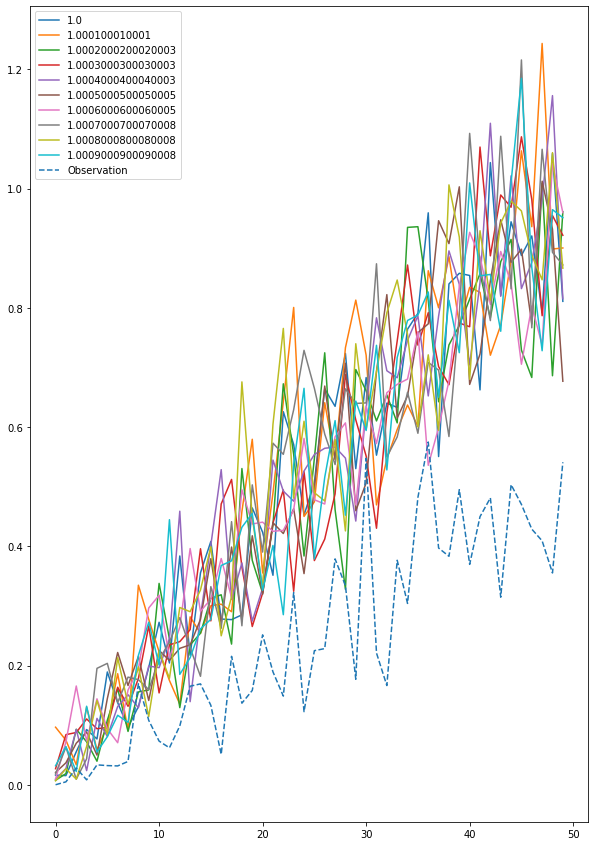

In [11]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(10):
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
#for index in range(n):
#    plt.plot(np.arange(n_vec), d_vec[index],)
plt.plot(np.arange(n_vec), d_vec_obs[0], label='Observation', linestyle='--')
plt.legend();

In [12]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the noise realisations
summaries_noise = []
for index in range(n):
    summaries_noise.append(compressor(d_vec_q[index]))
summaries_noise = np.asarray(summaries_noise)
summary_obs = compressor(d_vec_obs[0])
summary_obs = np.reshape(summary_obs, [1, 1])

In [13]:
compressor(d_vec_obs[0])

array([1.90824598])

In [14]:
compressed_data = summary_obs[0]

sim_params = np.reshape(q_prior, [-1, 1])

sim_compressed_data = summaries_noise

#Finv = np.genfromtxt('simulators/cosmic_shear/pre_ran_sims/Finv.dat')

theta_fiducial = np.array(q_fid)

## Create ensemble of NDEs


In [15]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=1, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]

## Create DELFI object

In [16]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,  
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['q'], 
                            results_dir = "./attempt_results")

## Load simulations into DELFI object

In [17]:
DelfiEnsemble.load_simulations(sim_compressed_data, sim_params)

# Train the networks

In [18]:
DelfiEnsemble.train_ndes()

In [19]:
# this should give us the log-likelihood
n_bins = 10000
posterior_params = np.linspace(1.0, 2.0, n_bins)
sim_params = np.copy(posterior_params)
likelihood_arr = np.zeros((n_bins, 2))
for index, q_value in enumerate(sim_params):
    likelihood_arr[index, :] = q_value, DelfiEnsemble.log_likelihood_stacked(q_value, compressed_data)

In [20]:
likelihood_arr = likelihood_arr[likelihood_arr[:,0].argsort()]
likelihood_arr[:, 1] = np.exp(likelihood_arr[:, 1])  # return to likelihood
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [21]:
import scipy.special as sps
theo_post = np.zeros((n_bins, 2))
for i, q in enumerate(sim_params):
    y = 1
    scale = q/n_vec
    for j in range(1, n_vec+1):
        shape = j / q**2
        y *= d_vec_obs[0, j-1]**(shape-1)*(np.exp(-d_vec_obs[0, j-1]/scale) / (sps.gamma(shape)*scale**shape))
    theo_post[i] = q, y
theo_post[:, 1] = theo_post[:, 1] / np.sum(theo_post[:, 1])

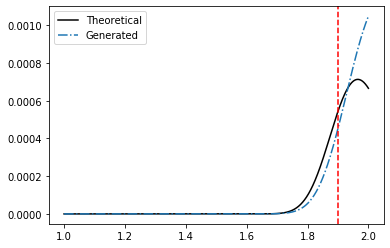

In [22]:
plt.plot(theo_post[:, 0],  theo_post[:, 1], c='k', label='Theoretical')
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.legend()
plt.axvline(q_fid_obs, linestyle='--', color='r')